<a href="https://colab.research.google.com/github/AlphaLock/Career_Accelerator_P5_NLP_Project_Work/blob/main/Azubi_P5_SentmentAnalysis_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis

In [ ]:
#setup
!pip install accelerate -U
!pip install datasets
!pip install huggingface-hub
!pip install datasets-cli
!pip install transformers
!pip install transformers[touch]
!pip install transformers[torch] accelerate>=0.20.1
!pip install --upgrade transformers accelerate
!pip install --upgrade transformers
!pip install accelerate -U
!pip install --upgrade torch
!pip install --upgrade accelerate --upgrade
!pip install git+https://github.com/huggingface/accelerate

In [ ]:
import gradio as gr

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from collections import Counter

# linear algebra
import numpy as np

# data processing
import pandas as pd

# For creating plots
import seaborn as sns

# For specifying the axes tick format
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

sns.set(style = 'white')


import os
from sklearn import preprocessing

#data split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [ ]:
# Load the train and test datasets
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

In [ ]:
train_data.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [ ]:
train_data.shape

(10001, 4)

## Data Cleaning

Let's explore the data to see if there are any missing values

In [ ]:
train_data.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

## Check for missing values

In [ ]:
train_data.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

## Remove missing values

In [ ]:
#Removing missing values
train_data.dropna(inplace = True)

In [ ]:
train_data.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

## Removing Tweet ID

In [ ]:
# Drop customer IDs
train_data = train_data .iloc[:,1:]

In [ ]:
train_data.head()

,safe_text,label,agreement
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,I mean if they immunize my kid with something ...,-1.0,1.0
4,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


# Exploratory Data Analysis

# Deep dive into the tweets column

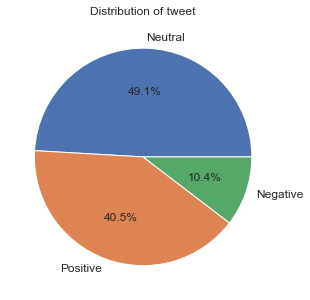

In [ ]:
ax = (train_data['label'].value_counts()*100.0 /len(train_data))\
.plot.pie(autopct='%.1f%%', labels = ['Neutral', 'Positive', 'Negative'],figsize =(5,5), fontsize = 12 )
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('',fontsize = 12)
ax.set_title('Distribution of tweet', fontsize = 12)

plt.show()

# Deep dive into the agreement column

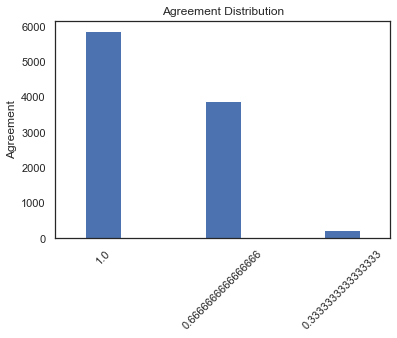

In [ ]:
ax = train_data['agreement'].value_counts().plot(kind = 'bar',rot = 45, width = 0.3)
ax.set_ylabel('Agreement')
ax.set_title('Agreement Distribution')

plt.show()

## Works on the roberta model

In [ ]:
Train, eval = train_test_split(Train, test_size=0.2, random_state=42, stratify= Train['label'])

In [ ]:
print(f"new dataframe shapes: train is {Train.shape}, eval is {eval.shape}")

In [ ]:
# Save splitted subsets
Train.to_csv("/content/drive/MyDrive/Azubi/Train.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Azubi/Test.csv", index=False)

dataset = load_dataset('csv',
                        data_files={'Train': "/content/drive/MyDrive/Azubi/Train.csv",
                        'eval': "/content/drive/MyDrive/Azubi/Train.csv"}, encoding = "ISO-8859-1")

In [ ]:
# Instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)

In [ ]:
## Function to transform labels
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [ ]:
## Function to tokenize data
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length',truncation=True, max_length = 256)

In [ ]:
# Tokenize the tweets
dataset = dataset.map(tokenize_data, batched=True)

In [ ]:
# Transform	labels and limit the columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

In [ ]:
pip show accelerate

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    "covid_tweets_sentiment_analysis_model",
    num_train_epochs=4,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch"
    )

In [ ]:
# Load the pretrained model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)

In [ ]:
# Define evaluation metrics
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Instantiate the training and evaluation sets
train_dataset = dataset["Train"].shuffle(seed=24)
eval_dataset = dataset["eval"].shuffle(seed=24)

In [ ]:
#converting training data to PyTorch tensors to speed up training and adding padding:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Reinstantiate the trainer for evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation
trainer.evaluate()